In [1]:
import os
import shap
import wandb
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from joblib import dump, load
from Soroosh_utilities import *
import tensorflow_probability as tfp
from Soroosh_feature_importance import *
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [2]:
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=6)



In [3]:
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers


In [4]:
if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))
    
    

## The purposes of this set of studies:

- We intent to predict the critical current, determine the important features, and visualize them.

- Previously, it has been done for real-world data. In this set of studies, not only will we repeat those experiments, but also we use the synthetically generated data to increase our test samples. To this end, we pursue the following framework.

    - 1) Train regressors on only real-world data;
    - 2) Train regressors on only synthetic data;
    - 3) Train regressors on combination of both (50%-50%).


- To this end we use, three regression algorithms: a)RF, b) GBR-LS, c) DNNR.

- Once the training is completed we will apply: 1) Gini-index, 2) Permutation, to determine the importance of features. Finally we use "Partial dependence" to visualize the impact of important features on the target values.


- Note: For more see the notion page below

https://www.notion.so/SuperOx-936b1b2ce7b14f20bd76578c82305e2b


Note: we studied and tuned the parameters in the previous jupyter notebook. Thus we will use them as the default and given here.

### Feature importance:

There exist several methods to determine the importance of features as follows.

1. **The coefficients of linear regression:**

    - Once the LR model is fitted, the weights can be used to interpret the features' importance.

    - cons: over-simplistic.


2. **Gini importance(or mean decrease in impurity) mechanism:** 

    - Gini importance is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value, the more important the feature. 
    
    In other words, the mean decrease in impurity importance of a feature is computed by measuring how effective the feature is at reducing uncertainty (classifiers) or variance (regressors) when creating decision trees within RFs.

    - Cons: impurity-based feature importances can be misleading for high cardinality features. (It tends to inflate the importance of continuous or high-cardinality categorical variables). 
    

3. **Permutation importance mechanism:** First, a baseline metric, defined by scoring, is evaluated on a (potentially different) dataset defined by the X. Next, a feature column from the validation set is permuted, and the metric is re-evaluated. The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.

    - Cons: computationally, more expensive than Gini importance, but still more reliable. Moreover, highly correlated features could yield biased estimations or overestimations of the importance of features (Strobl et al. (2007), Nicodemus et al. (2010)).


### Additive Feature Attribution Methods: (SHAP lib)

The best explanation of a simple model is the model itself; it perfectly represents itself and is easy to understand. For complex models, such as ensemble methods or deep networks, we cannot use the original model as its own best explanation because it is not easy to understand. Instead, we must use a simpler explanation model, which we define as any interpretable approximation of the original model. We show below that six current explanation methods from the literature all use the same explanation model. This previously unappreciated unity has interesting implications, which we describe in later sections.

Let $f$ be the original prediction model to be explained and $g$ the explanation model. 
Here, we focus on local methods designed to explain a prediction $f(x)$ based on a single input $x$. Explanation models often use simplified inputs $x′$ that map to the original inputs through a mapping function $x = h_x(x′)$. Local methods try to ensure $g(z′) ≈ f(h_x(z′))$ whenever $z′ ≈ x′$. (Note that $h_x(x′) = x$ even though $x′$ may contain less information than $x$ because $h_x$ is specific to the current input $x$.)





**Definition.**

Additive feature attribution methods have an explanation model that is a linear function of binary variables:

$g(z^′)=φ_0 + \sum_{i=1}^{M}φ_iz_i^{′} \ \ \ Eqn.(1) $ 


where $z′ \in \{0, 1\}^M$ , $M$ is the number of simplified input features, and $φ_i \mathbb{R}$.



4. **LIME:**

The LIME method interprets individual model predictions based on locally approximating the model around a given prediction. 
The local linear explanation model that LIME uses adheres to Equation 1 exactly and is thus an additive feature attribution method.
LIME refers to simplified inputs $x^′$ as “interpretable inputs,” and the mapping $x = h_x(x^′)$ converts a binary vector of interpretable inputs into the original input space. Different types of $h_x$ mappings are used for different input spaces. For bag of words text features, $h_x$ converts a vector of 1’s or 0’s (present or not) into the original word count if the simplified input is one, or zero if the simplified input is zero. For images, $h_x$ treats the image as a set of super pixels; it then maps 1 to leaving the super pixel as its original value and 0 to replacing the super pixel with an average of neighboring pixels (this is meant to represent being missing).



5. **DeepLIFT:**

DeepLIFT attributes to each input $x_i$ a value $C_{∆xi ∆y}$ that represents the effect of that input being set to a reference value as opposed to its original value. This means that for DeepLIFT, the mapping $x = h_x(x′)$ converts binary values into the original inputs, where 1 indicates that an input takes its original value, and 0 indicates that it takes the reference value. The reference value, though chosen by the user, represents a typical uninformative background value for the feature.
DeepLIFT uses a "summation-to-delta" property that states:  $ \sum_{i=1}^{n} C_{∆xi∆o} =∆o,$ 


where $o = f(x)$ is the model output, $∆_o = f(x) − f(r)$, $∆x_i = x_i − r_i$, and r is the reference input. If we let $φ_i = C_{∆xi∆o}$ and $φ_0 = f(r)$, then DeepLIFT’s explanation model matches Equation 1 and is thus another additive feature attribution method.


6. **Layer-Wise Relevance Propagation:**

The layer-wise relevance propagation method interprets the predictions of deep networks [1]. As noted by Shrikumar et al., this menthod is equivalent to DeepLIFT with the reference activations of all neurons fixed to zero. Thus, x = hx(x′) converts binary values into the original input space, where 1 means that an input takes its original value, and 0 means an input takes the 0 value. Layer-wise relevance propagation’s explanation model, like DeepLIFT’s, matches Equation 1.


7. **Shapley regression values** 
are feature importances for linear models in the presence of multicollinearity. This method requires retraining the model on all feature subsets $S ⊆ F$ , where $F$ is the set of all features. It assigns an importance value to each feature that represents the effect on the model prediction of including that feature. To compute this effect, a model $f_{S∪\{i\}}$ is trained with that feature present, and another model $fS$ is trained with the feature withheld. Then, predictions from the two models are compared on the current input $f_{S∪\{i\}}(x_{S∪\{i\}}) − f_S(x_S)$, where $x_S$ represents the values of the input features in the set $S$. Since the effect of withholding a feature depends on other features in the model, the preceding differences are computed for all possible subsets $S ⊆ F \ \{i\}$. The Shapley values are then computed and used as feature attributions. They are a weighted average of all possible differences (Eqn.(4) from [1]).


8. **Shapley sampling values**
are meant to explain any model by: (1) applying sampling approximations to Equation 4, and (2) approximating the effect of removing a variable from the model by integrating over samples from the training dataset. This eliminates the need to retrain the model and allows fewer than $2^{|F |}$ differences to be computed. Since the explanation model form of Shapley sampling values is the same as that for Shapley regression values, it is also an additive feature attribution method.

9. **Quantitative input influence**
is a broader framework that addresses more than feature attributions. However, as part of its method it independently proposes a sampling approximation to Shapley values that is nearly identical to Shapley sampling values. It is thus another additive feature attribution method.


**SHAP (SHapley Additive exPlanation) Values**: in [1] it was shown that indeed, 4,5, 6 corresponds to 7,8, 9 in respect. Thus the authors combined them together and proposed a library called "shap" to this end, with set of handy tools which we will use in this study.

10. **SHAP Feature Importance:** 

The idea behind SHAP feature importance is simple: Features with large absolute Shapley values are important. Since we want the global importance, we average the absolute Shapley values per feature across the data:

$$
I_j = \sum_{j=1}^{n} |\phi_j^{i}|
$$


Next, we sort the features by decreasing importance and plot them.

### Conclusion over feature importance methods:







[1]: Lundberg, S. and Lee, S.I., 2017. A unified approach to interpreting model predictions. arXiv preprint arXiv:1705.07874.

for high-level description, see https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d

### Initializatin for comparison of methods:

In [5]:
reg_algs = ['RF-Gini', 'RF-Perm', 'RF-Shap', 'GBR-Gini', 'GBR-Perm', 'GBR-Shap',
            'DNNR-Shap']  # Regression algorithms ('Bayes_Reg')
results = ['MAE', 'MRAE', 'RMSE', 'R^2-Score', 
           'Value, Name-1', 'Value, Name-2', 'Value, Name-3', 
           'Value, Name-4', 'Value, Name-5']  
df_cmp_real = pd.DataFrame(index=reg_algs, columns=results) 
df_cmp_real



,MAE,MRAE,RMSE,R^2-Score,"Value, Name-1","Value, Name-2","Value, Name-3","Value, Name-4","Value, Name-5"
RF-Gini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RF-Perm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RF-Shap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBR-Gini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBR-Perm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBR-Shap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DNNR-Shap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
reg_algs = ["Baseline-Shap", "SDNNR-Shap", 
            "SCNNR-Shap", "SRNNR-Shap", ]  # Regression algorithms ('Bayes_Reg')
results = ['MAE', 'MRAE', 'RMSE', 'R^2-Score', 
           'Value, Name-1', 'Value, Name-2', 'Value, Name-3', 
           'Value, Name-4', 'Value, Name-5']  
df_cmp_real_seq = pd.DataFrame(index=reg_algs, columns=results) 
df_cmp_real_seq




,MAE,MRAE,RMSE,R^2-Score,"Value, Name-1","Value, Name-2","Value, Name-3","Value, Name-4","Value, Name-5"
Baseline-Shap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SDNNR-Shap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SCNNR-Shap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRNNR-Shap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
reg_algs = ['RF-Gini', 'RF-Perm', 'GBR-Gini', 'GBR-Perm',
            'DNNR-Gini', 'DNNR-Perm']  # Regression algorithms ('Bayes_Reg')

results = ['MAE', 'MRAE', 'RMSE', 'R^2-Score', 
           'Value, Name-1', 'Value, Name-2', 'Value, Name-3', 
           'Value, Name-4', 'Value, Name-5']  

df_cmp_synthetic = pd.DataFrame(index=reg_algs, columns=results) 
df_cmp_synthetic



,MAE,MRAE,RMSE,R^2-Score,"Value, Name-1","Value, Name-2","Value, Name-3","Value, Name-4","Value, Name-5"
RF-Gini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RF-Perm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBR-Gini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBR-Perm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DNNR-Gini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DNNR-Perm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
reg_algs = ['RF-Gini', 'RF-Perm', 'GBR-Gini', 'GBR-Perm',
            'DNNR-Gini', 'DNNR-Perm']  # Regression algorithms ('Bayes_Reg')
results = ['MAE', 'MRAE', 'RMSE', 'R^2-Score', 
           'Value, Name-1', 'Value, Name-2', 'Value, Name-3', 
           'Value, Name-4', 'Value, Name-5']

df_cmp_combined = pd.DataFrame(index=reg_algs, columns=results) 
df_cmp_combined



,MAE,MRAE,RMSE,R^2-Score,"Value, Name-1","Value, Name-2","Value, Name-3","Value, Name-4","Value, Name-5"
RF-Gini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RF-Perm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBR-Gini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBR-Perm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DNNR-Gini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DNNR-Perm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Load dataset

In [9]:
# pld_complete = catalog.load('pld_complete').dropna().sort_values('pos', ascending=True)
# pld_complete_zscore = pd.read_csv("/home/soroosh/SearchOX/data/pld_complete_zscore.csv", index_col=False)


pld_complete_range = pd.read_csv("/home/soroosh/Desktop/SearchOX/data/pld_complete_range.csv",
                                 index_col=False)

# pld_complete_range_synthetic = np.loadtxt("/home/soroosh/Desktop/SearchOX/data/x_r_synthetic.npy")



In [59]:
pld_complete_range.head()


,median_Voltage_HSR_V_1025,median_Voltage_HSR_V_1027,median_Voltage_HSR_V_1030,median_Voltage_HSL_V_1025,median_Voltage_HSL_V_1027,median_Voltage_HSL_V_1030,median_Voltage_HF_V_1025,median_Voltage_HF_V_1027,median_Voltage_HF_V_1030,median_Voltage_HC_V_1025,...,std_Sigma_1030,pos,Speed,X FWHM,Y FWHM,R FWHM,Coolness,Coolness_neg,Ic,Ic_norm
0,0.129479,0.177414,0.005142,0.69562,-0.256257,-0.015406,-0.009215,-0.072807,-0.021102,0.057123,...,-0.390667,-0.501695,0.009841,0.039589,0.067470,0.015697,0.053006,-0.086369,496.2,1.767913
1,0.110059,0.340245,0.005142,0.69562,-0.321465,-0.015406,-0.009215,-0.173901,-0.021102,0.050178,...,-0.390667,-0.501652,-0.005266,0.039589,0.067470,0.015697,0.053006,-0.086369,494.7,1.762568
2,0.119769,0.340245,0.005142,0.69562,-0.321465,-0.015406,-0.007363,-0.173901,-0.021102,0.057123,...,-0.390667,-0.501646,-0.007197,0.039589,0.067470,0.015697,0.053006,-0.086369,494.2,1.760787
3,0.110059,0.348139,0.005142,0.69562,-0.322354,-0.015406,-0.009215,-0.218270,-0.021102,0.057123,...,-0.390667,-0.501635,-0.010946,0.039589,0.067470,0.015697,0.053006,-0.086369,495.5,1.765419
4,0.110059,0.264593,0.005142,0.69562,-0.305820,-0.015406,-0.009215,-0.129533,-0.021102,0.057123,...,-0.390667,-0.501619,-0.017147,0.042682,0.069442,0.017956,0.051965,-0.084836,497.9,1.773168


## splitting the sequential data

### Real data

In [11]:
x_r_real = pld_complete_range.loc[:,
                                  ~pld_complete_range.columns.isin(['Ic', 'Ic_norm', 'pos'])]  # .to_numpy()

y_ic_real = pld_complete_range['Ic']  # .to_numpy()
y_ic_norm_real = pld_complete_range['Ic_norm']  # .to_numpy()
pos_real = pld_complete_range['pos']  # .to_numpy()

x_r_real.shape, y_ic_real.shape, y_ic_norm_real.shape, pos_real.shape



((18561, 376), (18561,), (18561,), (18561,))

In [12]:
pos_idx = pld_complete_range.columns.get_loc("pos")
ic_idx = pld_complete_range.columns.get_loc("Ic")
ic_norm_idx = pld_complete_range.columns.get_loc("Ic_norm")
pos_idx, ic_idx, ic_norm_idx


(370, 377, 378)

In [13]:
n_epochs = 1000  # previously, it was 500
learning_rate = 1e-5  # [1e-2, 1e-3, 1e-5] 
batch_size = 64  # [32, 64, 256]
n_units = 128

input_shape = (x_r_real.shape[1])  



### save synthetic data as df and then modify the two (four) cell below 

In [14]:
# x_r_synthetic_1 = pld_complete_range_synthetic[:, : pos_idx]
# x_r_synthetic_2 = pld_complete_range_synthetic[:, pos_idx+1:ic_idx]


# x_r_synthetic = np.concatenate([x_r_synthetic_1, x_r_synthetic_2], axis=1)
# x_r_synthetic_1.shape, x_r_synthetic_2.shape, x_r_synthetic.shape



In [15]:
# y_ic_synthetic = pld_complete_range_synthetic[:, ic_idx]
# y_ic_norm_synthetic = pld_complete_range_synthetic[:, ic_norm_idx] 
# pos_synthetic = pld_complete_range_synthetic[:, pos_idx]

# x_r_synthetic.shape, y_ic_synthetic.shape, y_ic_norm_synthetic.shape, pos_synthetic.shape



In [16]:
# x_r_combined = np.concatenate([x_r_real, x_r_synthetic], axis=0)
# y_ic_combined = np.concatenate([y_ic_real, y_ic_synthetic], axis=0)
# y_ic_norm_combined = np.concatenate([y_ic_norm_real, y_ic_norm_synthetic], axis=0)

# x_r_combined.shape, y_ic_combined.shape, y_ic_norm_combined.shape



In [17]:
assert not np.any(np.isnan(x_r_real))
# assert not x_r_real.shape != x_r_synthetic.shape
# assert not x_r_combined.shape[0] != int(2*x_r_synthetic.shape[0])



## splitting the non-sequential data

### Real data

In [18]:
x_r_train_real, x_r_test_real, \
y_train_real, y_test_real = train_test_split(x_r_real,
                                             y_ic_norm_real,
                                             test_size=0.40,
                                             random_state=43,)

x_r_val_real, x_r_test_real, \
y_val_real, y_test_real = train_test_split(x_r_test_real,
                                           y_test_real,
                                           test_size=0.5,
                                           random_state=43,)


x_r_train_real.shape, x_r_test_real.shape, \
x_r_val_real.shape, y_train_real.shape, \
y_test_real.shape, y_val_real.shape



((11136, 376), (3713, 376), (3712, 376), (11136,), (3713,), (3712,))

In [60]:
pld_complete_range_ = pld_complete_range.loc[:,
                                             ~pld_complete_range.columns.isin(['Ic', 'pos'])]

column_indices = {name: i for i, name in enumerate(pld_complete_range_.columns)}

n = len(x_r_real)
x_r_train_real_seq = pld_complete_range_[0:int(n*0.6)]
y_train_real_seq = y_ic_norm_real[0:int(n*0.6)]

x_r_val_real_seq = pld_complete_range_[int(n*0.6):int(n*0.8)]
y_val_real_seq = y_ic_norm_real[int(n*0.6):int(n*0.8)]


x_r_test_real_seq = pld_complete_range_[int(n*0.8):]
y_test_real_seq = pld_complete_range_[int(n*0.8):]



x_r_train_real_seq.shape, x_r_test_real_seq.shape, \
x_r_val_real_seq.shape, y_train_real_seq.shape, \
y_test_real_seq.shape, y_val_real_seq.shape



((11136, 377), (3713, 377), (3712, 377), (11136,), (3713, 377), (3712,))

In [20]:
# x_r_train_synthetic, x_r_test_synthetic,\
# y_train_synthetic, y_test_synthetic = train_test_split(x_r_synthetic,
#                                                        y_ic_norm_synthetic,
#                                                        test_size=0.40,
#                                                        random_state=43,)

# x_r_val_synthetic, x_r_test_synthetic,\
# y_val_synthetic, y_test_synthetic = train_test_split(x_r_test_synthetic,
#                                                      y_test_synthetic,
#                                                      test_size=0.5,
#                                                      random_state=43,)


# x_r_train_synthetic.shape, x_r_test_synthetic.shape, \
# x_r_val_synthetic.shape, y_train_synthetic.shape,  y_test_synthetic.shape, y_val_synthetic.shape

### Combined data



In [21]:
# x_r_train_combined, x_r_test_combined, \
# y_train_combined, y_test_combined = train_test_split(x_r_combined,
#                                                      y_ic_norm_combined,
#                                                      test_size=0.40,
#                                                      random_state=43,)

# x_r_val_combined, x_r_test_combined, \
# y_val_combined, y_test_combined = train_test_split(x_r_test_combined,
#                                                    y_test_combined,
#                                                    test_size=0.5,
#                                                    random_state=43,)


# x_r_train_combined.shape, x_r_test_combined.shape, \
# x_r_val_combined.shape, y_train_combined.shape, \
# y_test_combined.shape, y_val_combined.shape



## Determining the importance of features
A) Permutation
B) Gini-index
C)Shap

## Training RF

- For more about tuning the parameters see the u01-*.ipynb 

In [22]:
def train_eval_rf(x_train, y_train, x_test, y_test, name):
    
    rf_reg = RandomForestRegressor(n_estimators=100, 
                                   n_jobs=-2, 
                                   criterion='mse', 
                                   min_samples_leaf=1,
                                   verbose=1)
    
    rf_reg.fit(x_train, y_train)
    
    y_preds_rf = rf_reg.predict(x_test)
    
    filename = "rf_reg-" + name +  "-.joblib"
    dump(rf_reg, "../saved_model/"+ filename )
    
    features_importance_gini = rf_reg.feature_importances_
    
    features_importance_perm = permutation_importance(estimator=rf_reg,
                                                      X=x_test, y=y_test,
                                                      n_repeats=5,
                                                      n_jobs=-2,
                                                      random_state=0)
    
    explainer, features_importance_shap = apply_shap_summary_plot(model=rf_reg,
                                                                  x_train=x_train, y_train=y_train, 
                                                                  x_test=x_test, y_test=y_test, 
                                                                  n_clusters=10,
                                                                  model_name="RF", data_type=name
                                                                 )
    
    
    return y_preds_rf, features_importance_gini, features_importance_perm, features_importance_shap, rf_reg


## Train Gradient Boosting Regressor


In [23]:
def train_eval_gbr(x_train, y_train, x_test, y_test, name):
    
    gbr_ls = GradientBoostingRegressor(loss='ls', verbose=1,)
    gbr_ls.fit(x_train, y_train)
    y_preds_gbr_ls = gbr_ls.predict(x_test)
    
    features_importance_gini = gbr_ls.feature_importances_
    
    features_importance_perm = permutation_importance(estimator=gbr_ls,
                                                     X=x_test, y=y_test,
                                                     n_repeats=5,
                                                     n_jobs=-2,
                                                     random_state=0)
    
    filename = "gbr_ls-" + name +  "-.joblib"
    dump(gbr_ls, "../saved_model/"+ filename )
        
    
    explainer, features_importance_shap = apply_shap_summary_plot(model=gbr_ls,
                                                      x_train=x_train, y_train=y_train, 
                                                      x_test=x_test, y_test=y_test, 
                                                      n_clusters=10,
                                                      model_name="GBR", data_type=name
                                                     )
    
#     features_importance_shap = shap_importance(shap_values, x_test)

    
    return y_preds_gbr_ls, features_importance_gini, features_importance_perm, features_importance_shap, gbr_ls



## DNN-Regressor



In [24]:
class DnnReg(tfk.Model):
    
    def __init__(self, n_units, n_features, name='dnn_reg', **kwargs):
        super(DnnReg, self).__init__(name=name, **kwargs)
        self.n_units = n_units
        self.n_features = n_features
        
        self.input_layer = tfkl.InputLayer(input_shape=self.n_features)
        self.cast_layer = tfkl.Lambda(lambda x: tf.cast(x, tf.float32))
        self.dense_1 = tfkl.Dense(units=int(.5*self.n_units), activation=tf.nn.leaky_relu)
        self.dense_2 = tfkl.Dense(units=self.n_units, activation=tf.nn.leaky_relu)
        self.dense_3 = tfkl.Dense(units=2*self.n_units, activation=tf.nn.leaky_relu,)
        self.dense_4 = tfkl.Dense(units=4*self.n_units, activation=tf.nn.leaky_relu,)
        self.regressor = tfkl.Dense(units=1)
        
    def call(self, inputs):
        x = self.input_layer(inputs)
        x = self.cast_layer(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        x = self.dense_4(x)
        regression = self.regressor(x)
        return regression
        

In [25]:
def train_eval_dnn_reg(dnn_reg, x_train, y_train, x_val, y_val, x_test, y_test, name):

    callback = tfk.callbacks.EarlyStopping(monitor='loss', patience=5)  # for early-stop

    dnn_reg.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                    loss='mse',
                   )

    history_dnn_ref = dnn_reg.fit(x=x_train, y=y_train,
                                  epochs=n_epochs, batch_size=batch_size,
                                  validation_data=(x_val, y_val),
                                  # callbacks=[callback],
                                 )


    filename = "dnn-reg-" + name 
    dnn_reg.save_weights('../saved_model/' + filename + '.h5')

    y_preds_dnn_reg = dnn_reg.predict(x_test)
    
    
    explainer, features_importance_shap = apply_shap_summary_plot(model=dnn_reg,
                                                     x_train=x_train, 
                                                     y_train=y_train, 
                                                     x_test=x_test, 
                                                     y_test=y_test, 
                                                     n_clusters=10,
                                                     model_name="DNNR", 
                                                     data_type=name
                                                    )
    
    
    print("y_preds_dnn_reg:", y_preds_dnn_reg.shape)
    
    return y_preds_dnn_reg, features_importance_shap, dnn_reg



# Real-only data 

## RF

In [26]:

# rnd_sample = np.random.randint(0, 10000, size=(1000))

# x_r_train_real = x_r_train_real.iloc[rnd_sample, 370:]
# y_train_real = y_train_real.iloc[rnd_sample]

# rnd_sample = np.random.randint(0, 3000, size=(500))
# x_r_val_real = x_r_val_real.iloc[rnd_sample, 370:]
# y_val_real = y_val_real.iloc[rnd_sample]

# rnd_sample = np.random.randint(0, 3000, size=(500))
# x_r_test_real = x_r_test_real.iloc[rnd_sample, 370: ]
# y_test_real = y_test_real.iloc[rnd_sample]


# print(x_r_train_real.shape, x_r_val_real.shape, x_r_test_real.shape, 
#       y_train_real.shape, y_val_real.shape, y_test_real.shape, )



In [27]:

# rnd_sample = np.random.choice(train_df_real.index, 100)



# train_df = pld_complete_range_.iloc[:1000, 370:]
# val_df = pld_complete_range_.iloc[1000:1500, 370:]
# test_df = pld_complete_range_.iloc[1500:2000, 370:]


# x_r_train_real_seq = x_r_train_real_seq.iloc[:100, 370:]
# y_train_real_seq = y_train_real_seq.iloc[:100, ]
# x_r_val_real_seq = x_r_val_real_seq.iloc[:100, 370:]
# y_val_real_seq = y_val_real_seq.iloc[:100,]
# x_r_test_real_seq = x_r_test_real_seq.iloc[:100, 370:]
# y_test_real_seq = y_test_real_seq.iloc[:100, ]

# train_df.shape, test_df.shape, val_df.shape


## WandB 

In [28]:
def init_a_wandb(name, project, notes, group):
    
    """ name := the within the project name, e.g., RF-reg-1
        project := the project name, e.g., Non-sequential Regressions 
        notes := Description, e.g., Non-sequential Regressions Comparison for SuperOX
        group := name of experiment or the algorithm under consideration, e.g., RF-1
    """
    
    run = wandb.init(name=name, 
                     project=project, 
                     notes = notes,
                     entity='sorooshi',
                     group=group
                    )
    
    return run



In [29]:
def wandb_metrics(run, y_trues, y_preds):
    
    run.log({
        "MAE" : mae(y_trues=y_trues, y_preds=y_preds),
        "MRAE" : mrae(y_trues=y_trues, y_preds=y_preds),
        "RMSE" : rmse(y_trues=y_trues, y_preds=y_preds),
        "R^2-Score": metrics.r2_score(y_trues, y_preds)
    })
    
    return run



In [48]:
def save_model(run, model, name, experiment_name):
    
    if name == "rf" or name == "gbr":
        dump(model, os.path.join(wandb.run.dir,
                          name + experiment_name + ".joblib"))
        
    elif name == "dnnr":
        model.save_weights(os.path.join(wandb.run.dir,
                                        name + experiment_name + ".h5"))
    else:
        model.save(os.path.join(wandb.run.dir,
                                name + experiment_name + ".h5"))
    return run


In [31]:

project = "Non-sequential Regressions-all"



In [32]:
def train_eval_a_nonsequential_regressor(x_train, y_train, x_val, y_val, x_test, 
                                         y_test, df_cmp, algorithm, data_type):
    
    # wandb initilization        
    run = init_a_wandb(name=None, 
                       project=project,
                       notes="Non-sequential Regressions Comparison for SuperOX " + data_type, 
                       group=algorithm
                      )
    
    if algorithm.lower() == "rf":

        y_preds, features_importance_gini, \
        features_importance_perm, \
        features_importance_shap, model = train_eval_rf(x_train=x_train,
                                                 y_train=y_train, 
                                                 x_test=x_test,
                                                 y_test=y_test,
                                                 name=data_type
                                                )

        
    elif algorithm.lower() == "gbr":
        
        y_preds, features_importance_gini, \
        features_importance_perm, \
        features_importance_shap, model = train_eval_gbr(x_train=x_train,
                                                  y_train=y_train, 
                                                  x_test=x_test,
                                                  y_test=y_test,
                                                  name=data_type
                                                 )
        
    elif algorithm.lower() == "dnnr":
        
        dnn_reg = DnnReg(n_units=n_units, n_features=[x_train.shape[1]])
        n_features=[x_train.shape[1]]
        print("n_features=[x_train.shape[1]]:", n_features)
        
        y_preds, features_importance_shap, model = train_eval_dnn_reg(dnn_reg=dnn_reg, 
                                                               x_train=x_train, 
                                                               y_train=y_train, 
                                                               x_test=x_test,
                                                               y_test=y_test,
                                                               x_val=x_val,
                                                               y_val=y_val,
                                                               name=data_type
                                                              )
        
        shap_indices = features_importance_shap[0]
        shap_val = features_importance_shap[1]
        shap_name = features_importance_shap[2]


        df_cmp = final_comparison(df=df_cmp, 
                                   y_preds=y_preds,
                                   y_trues=y_test, 
                                   name=algorithm+'-Shap',
                                   data_name=data_type,
                                   indices=shap_indices,
                                   values_features_importance=shap_val,
                                   name_important_features=shap_name
                                  )
        print(" Shap is done!")
        
    
    run = wandb_metrics(run=run, y_trues=y_test, y_preds=y_preds)
        
    run = save_model(run=run, model=model, 
                     name=algorithm.lower(), 
                     experiment_name=algorithm+"-"+data_type)
    
    
    if algorithm.lower() == 'rf' or algorithm.lower() == 'gbr':
        

        gini_indices, gini_val, \
        gini_name = apply_gini(estimator_important_features=features_importance_gini,
                               pld_complete=x_test, name=algorithm
                              )


        df_cmp = final_comparison(df=df_cmp, 
                                  y_preds=y_preds,
                                  y_trues=y_test, 
                                  name=algorithm+'-Gini',
                                  data_name=data_type,
                                  indices=gini_indices,
                                  values_features_importance=gini_val,
                                  name_important_features=gini_name
                                 )

        print(" Gini is done!")

        perm_indices, perm_val, \
        perm_name = apply_permutation(estimator_important_features=features_importance_perm,
                                      pld_complete=x_test, name=algorithm)



        df_cmp = final_comparison(df=df_cmp, 
                                  y_preds=y_preds,
                                  y_trues=y_test, 
                                  name=algorithm+'-Perm',
                                  data_name=data_type,
                                  indices=perm_indices,
                                  values_features_importance=perm_val,
                                  name_important_features=perm_name
                                 )
        
        print(" Perm. is done!")


        
        shap_indices = features_importance_shap[0]
        shap_val = features_importance_shap[1]
        shap_name = features_importance_shap[2]

        df_cmp = final_comparison(df=df_cmp, 
                                   y_preds=y_preds,
                                   y_trues=y_test, 
                                   name=algorithm+'-Shap',
                                   data_name=data_type,
                                   indices=shap_indices,
                                   values_features_importance=shap_val,
                                   name_important_features=shap_name
                                  )
        print(" Shap is done!")


    return df_cmp


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sorooshi (use `wandb login --relogin` to force relogin)


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  20 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:   28.6s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished


  0%|          | 0/3713 [00:00<?, ?it/s]

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0

Gini-index important Features w.r.t RF Reg.!   
 Gini is done!
features_indices: [  2 258 132   5   6 268  20  21 278 151 280 281 282 279  28 157 286 289
  35 294  39 298 299 176 178 179 180 181 182 306 319 192 194 196 197  70
 324  72 201 332 206 335 209  82 210 211 212 342 215  89 348  96 248 230
 359 108 236 365 241 371 372 245 246 375 373 121 374 251 126 127]
Permutation important Features w.r.t RF Reg.:
 Perm. is done!
 Shap is done!
CPU times: user 1h 29min 47s, sys: 1h 19min 54s, total: 2h 49min 42s
Wall time: 39min 46s


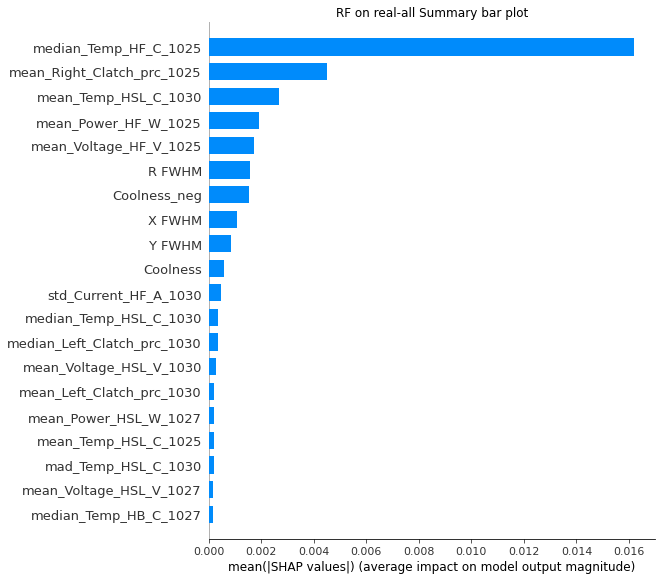

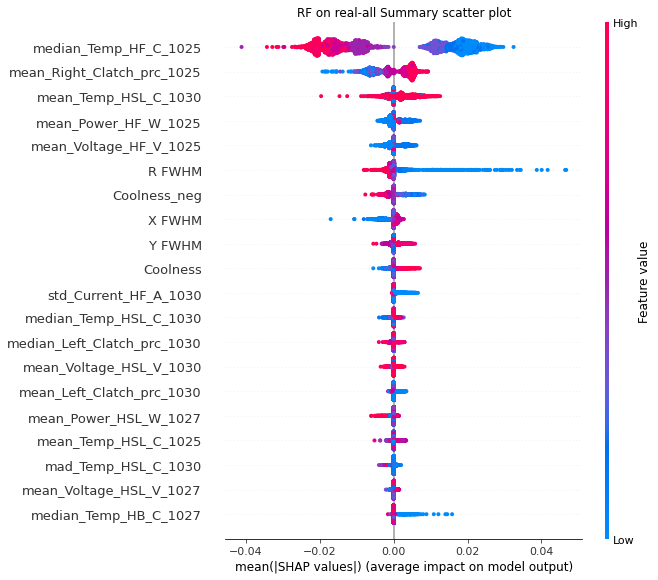

In [33]:
%%time
tmp = train_eval_a_nonsequential_regressor(x_train=x_r_train_real,
                         y_train=y_train_real, 
                         x_val=x_r_val_real, 
                         y_val=y_val_real,
                         x_test=x_r_test_real,
                         y_test=y_test_real, 
                         df_cmp=df_cmp_real,
                         algorithm="RF", 
                         data_type="real-all")




In [34]:
tmp



,MAE,MRAE,RMSE,R^2-Score,"Value, Name-1","Value, Name-2","Value, Name-3","Value, Name-4","Value, Name-5"
RF-Gini,0.010692,0.006285,0.017885,0.74673,"(0.37154, median_Temp_HF_C_1025)","(0.09166, mean_Right_Clatch_prc_1025)","(0.04252, mean_Temp_HSL_C_1030)","(0.02766, R FWHM)","(0.01740, Coolness_neg)"
RF-Perm,0.010692,0.006285,0.017885,0.74673,"(0.65639, median_Temp_HF_C_1025)","(0.10098, mean_Temp_HSL_C_1030)","(0.07108, R FWHM)","(0.07002, mean_Right_Clatch_prc_1025)","(0.03155, Coolness_neg)"
RF-Shap,0.010692,0.006285,0.017885,0.74673,"(0.01619, median_Temp_HF_C_1025)","(0.00449, mean_Right_Clatch_prc_1025)","(0.00268, mean_Temp_HSL_C_1030)","(0.00192, mean_Power_HF_W_1025)","(0.00174, mean_Voltage_HF_V_1025)"
GBR-Gini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBR-Perm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GBR-Shap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DNNR-Shap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


MAE,0.01069
MRAE,0.00628
RMSE,0.01789
R^2-Score,0.74673
_runtime,2386
_timestamp,1618317762
_step,0


MAE,▁
MRAE,▁
RMSE,▁
R^2-Score,▁
_runtime,▁
_timestamp,▁
_step,▁


      Iter       Train Loss   Remaining Time 
         1           0.0011            1.12m
         2           0.0010            1.08m
         3           0.0009            1.06m
         4           0.0008            1.05m
         5           0.0007            1.04m
         6           0.0007            1.03m
         7           0.0007            1.02m
         8           0.0006            1.01m
         9           0.0006           59.80s
        10           0.0006           58.93s
        20           0.0005           52.46s
        30           0.0004           46.23s
        40           0.0004           39.91s
        50           0.0004           33.41s
        60           0.0004           26.71s
        70           0.0004           19.95s
        80           0.0003           13.23s
        90           0.0003            6.59s
       100           0.0003            0.00s


  0%|          | 0/3713 [00:00<?, ?it/s]

Gini-index important Features w.r.t GBR Reg.!   
 Gini is done!
features_indices: [257 258   6 262   9  20  21 155 289  35 294 296  41 169 175 178 179 180
 182 185 189 194 196 197  72 202  82 210 212 343 348 236 237 239 241 114
 370 371 372 373 375 248 251 127]
Permutation important Features w.r.t GBR Reg.:
 Perm. is done!
 Shap is done!
CPU times: user 48min 27s, sys: 1h 3min 35s, total: 1h 52min 3s
Wall time: 28min 23s


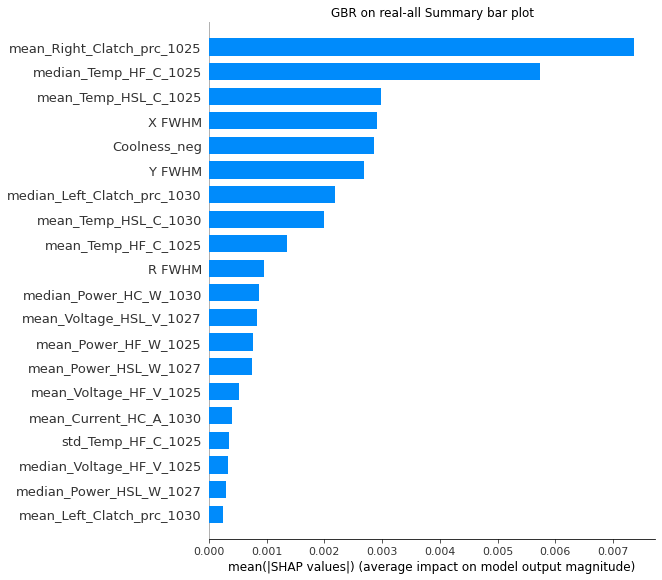

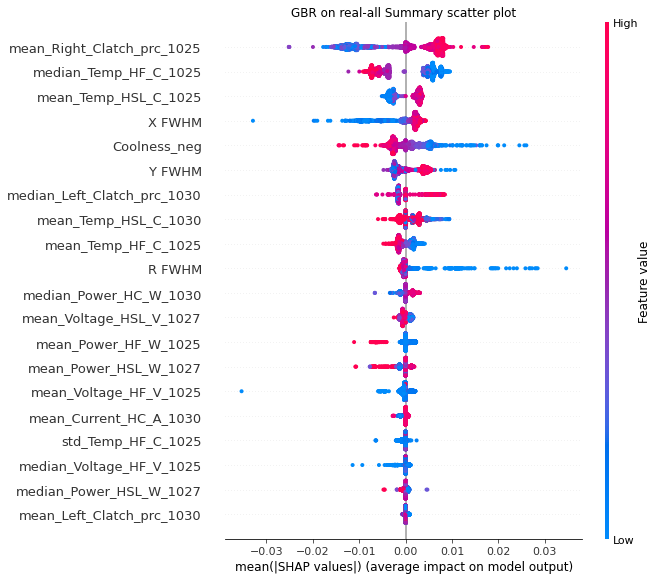

In [35]:
%%time
tmp = train_eval_a_nonsequential_regressor(x_train=x_r_train_real,
                                           y_train=y_train_real, 
                                           x_val=x_r_val_real,
                                           y_val=y_val_real,
                                           x_test=x_r_test_real, 
                                           y_test=y_test_real, 
                                           df_cmp=df_cmp_real,
                                           algorithm="GBR", 
                                           data_type="real-all")



In [36]:
tmp



,MAE,MRAE,RMSE,R^2-Score,"Value, Name-1","Value, Name-2","Value, Name-3","Value, Name-4","Value, Name-5"
RF-Gini,0.010692,0.006285,0.017885,0.746730,"(0.37154, median_Temp_HF_C_1025)","(0.09166, mean_Right_Clatch_prc_1025)","(0.04252, mean_Temp_HSL_C_1030)","(0.02766, R FWHM)","(0.01740, Coolness_neg)"
RF-Perm,0.010692,0.006285,0.017885,0.746730,"(0.65639, median_Temp_HF_C_1025)","(0.10098, mean_Temp_HSL_C_1030)","(0.07108, R FWHM)","(0.07002, mean_Right_Clatch_prc_1025)","(0.03155, Coolness_neg)"
RF-Shap,0.010692,0.006285,0.017885,0.746730,"(0.01619, median_Temp_HF_C_1025)","(0.00449, mean_Right_Clatch_prc_1025)","(0.00268, mean_Temp_HSL_C_1030)","(0.00192, mean_Power_HF_W_1025)","(0.00174, mean_Voltage_HF_V_1025)"
GBR-Gini,0.014165,0.008317,0.021276,0.641596,"(0.30467, median_Temp_HF_C_1025)","(0.23305, mean_Right_Clatch_prc_1025)","(0.07652, mean_Temp_HSL_C_1025)","(0.04677, Y FWHM)","(0.04567, mean_Temp_HSL_C_1030)"
GBR-Perm,0.014165,0.008317,0.021276,0.641596,"(0.14245, mean_Right_Clatch_prc_1025)","(0.07805, median_Temp_HF_C_1025)","(0.04576, median_Left_Clatch_prc_1030)","(0.03544, X FWHM)","(0.02883, mean_Temp_HSL_C_1030)"
GBR-Shap,0.014165,0.008317,0.021276,0.641596,"(0.00736, mean_Right_Clatch_prc_1025)","(0.00573, median_Temp_HF_C_1025)","(0.00298, mean_Temp_HSL_C_1025)","(0.00290, X FWHM)","(0.00286, Coolness_neg)"
DNNR-Shap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


MAE,0.01417
MRAE,0.00832
RMSE,0.02128
R^2-Score,0.6416
_runtime,1675
_timestamp,1618319466
_step,0


MAE,▁
MRAE,▁
RMSE,▁
R^2-Score,▁
_runtime,▁
_timestamp,▁
_step,▁


n_features=[x_train.shape[1]]: [376]
Epoch 1/1000
174/174 [==============================] - 1s 4ms/step - loss: 2.8013 - val_loss: 1.9812
Epoch 2/1000
174/174 [==============================] - 0s 2ms/step - loss: 1.6195 - val_loss: 0.5263
Epoch 3/1000
174/174 [==============================] - 0s 2ms/step - loss: 0.3162 - val_loss: 0.0575
Epoch 4/1000
174/174 [==============================] - 0s 2ms/step - loss: 0.0536 - val_loss: 0.0457
Epoch 5/1000
174/174 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0385
Epoch 6/1000
174/174 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0327
Epoch 7/1000
174/174 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0280
Epoch 8/1000
174/174 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0243
Epoch 9/1000
174/174 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0214
Epoch 10/1000
174/174 [======================

174/174 [==============================] - 0s 2ms/step - loss: 9.0502e-04 - val_loss: 0.0011
Epoch 81/1000
174/174 [==============================] - 0s 2ms/step - loss: 8.6392e-04 - val_loss: 0.0011
Epoch 82/1000
174/174 [==============================] - 0s 2ms/step - loss: 8.7888e-04 - val_loss: 0.0011
Epoch 83/1000
174/174 [==============================] - 0s 2ms/step - loss: 8.6516e-04 - val_loss: 0.0011
Epoch 84/1000
174/174 [==============================] - 0s 2ms/step - loss: 8.2249e-04 - val_loss: 0.0011
Epoch 85/1000
174/174 [==============================] - 0s 2ms/step - loss: 8.4203e-04 - val_loss: 0.0011
Epoch 86/1000
174/174 [==============================] - 0s 2ms/step - loss: 8.0721e-04 - val_loss: 0.0011
Epoch 87/1000
174/174 [==============================] - 0s 2ms/step - loss: 8.2345e-04 - val_loss: 0.0010
Epoch 88/1000
174/174 [==============================] - 0s 2ms/step - loss: 8.0110e-04 - val_loss: 0.0010
Epoch 89/1000
174/174 [============================

Epoch 154/1000
174/174 [==============================] - 0s 2ms/step - loss: 4.4596e-04 - val_loss: 6.8189e-04
Epoch 155/1000
174/174 [==============================] - 0s 2ms/step - loss: 4.3122e-04 - val_loss: 7.1697e-04
Epoch 156/1000
174/174 [==============================] - 0s 2ms/step - loss: 4.3588e-04 - val_loss: 6.6171e-04
Epoch 157/1000
174/174 [==============================] - 0s 2ms/step - loss: 4.3085e-04 - val_loss: 7.0125e-04
Epoch 158/1000
174/174 [==============================] - 0s 2ms/step - loss: 4.3286e-04 - val_loss: 6.7316e-04
Epoch 159/1000
174/174 [==============================] - 0s 2ms/step - loss: 4.3117e-04 - val_loss: 6.6315e-04
Epoch 160/1000
174/174 [==============================] - 0s 2ms/step - loss: 4.1828e-04 - val_loss: 6.4909e-04
Epoch 161/1000
174/174 [==============================] - 0s 2ms/step - loss: 4.2483e-04 - val_loss: 6.4921e-04
Epoch 162/1000
174/174 [==============================] - 0s 2ms/step - loss: 4.2995e-04 - val_loss: 6.4

174/174 [==============================] - 0s 2ms/step - loss: 2.4811e-04 - val_loss: 5.2076e-04
Epoch 301/1000
174/174 [==============================] - 0s 2ms/step - loss: 2.4108e-04 - val_loss: 5.2490e-04
Epoch 302/1000
174/174 [==============================] - 0s 2ms/step - loss: 2.5338e-04 - val_loss: 5.1936e-04
Epoch 303/1000
174/174 [==============================] - 0s 2ms/step - loss: 2.3991e-04 - val_loss: 5.3469e-04
Epoch 304/1000
174/174 [==============================] - 0s 2ms/step - loss: 2.4716e-04 - val_loss: 5.2490e-04
Epoch 305/1000
174/174 [==============================] - 0s 2ms/step - loss: 2.4347e-04 - val_loss: 5.3136e-04
Epoch 306/1000
174/174 [==============================] - 0s 2ms/step - loss: 2.5156e-04 - val_loss: 5.2295e-04
Epoch 307/1000
174/174 [==============================] - 0s 2ms/step - loss: 2.4076e-04 - val_loss: 5.2929e-04
Epoch 308/1000
174/174 [==============================] - 0s 2ms/step - loss: 2.4198e-04 - val_loss: 5.4288e-04
Epoch 3

174/174 [==============================] - 0s 2ms/step - loss: 1.7216e-04 - val_loss: 5.1151e-04
Epoch 447/1000
174/174 [==============================] - 0s 2ms/step - loss: 1.7634e-04 - val_loss: 4.9343e-04
Epoch 448/1000
174/174 [==============================] - 0s 2ms/step - loss: 1.7398e-04 - val_loss: 4.8903e-04
Epoch 449/1000
174/174 [==============================] - 0s 2ms/step - loss: 1.6980e-04 - val_loss: 4.9631e-04
Epoch 450/1000
174/174 [==============================] - 0s 2ms/step - loss: 1.6427e-04 - val_loss: 4.9448e-04
Epoch 451/1000
174/174 [==============================] - 0s 2ms/step - loss: 1.6143e-04 - val_loss: 4.9296e-04
Epoch 452/1000
174/174 [==============================] - 0s 2ms/step - loss: 1.7443e-04 - val_loss: 4.9269e-04
Epoch 453/1000
174/174 [==============================] - 0s 2ms/step - loss: 1.6786e-04 - val_loss: 4.9464e-04
Epoch 454/1000
174/174 [==============================] - 0s 2ms/step - loss: 1.7622e-04 - val_loss: 5.0133e-04
Epoch 4

174/174 [==============================] - 0s 2ms/step - loss: 1.2497e-04 - val_loss: 4.8653e-04
Epoch 593/1000
174/174 [==============================] - 0s 2ms/step - loss: 1.2706e-04 - val_loss: 4.8732e-04
Epoch 594/1000
174/174 [==============================] - 0s 2ms/step - loss: 1.2222e-04 - val_loss: 4.8559e-04
Epoch 595/1000
174/174 [==============================] - 0s 2ms/step - loss: 1.1995e-04 - val_loss: 4.8337e-04
Epoch 596/1000
174/174 [==============================] - 0s 2ms/step - loss: 1.2167e-04 - val_loss: 4.8304e-04
Epoch 597/1000
174/174 [==============================] - 0s 2ms/step - loss: 1.2896e-04 - val_loss: 4.9082e-04
Epoch 598/1000
174/174 [==============================] - 0s 2ms/step - loss: 1.2440e-04 - val_loss: 4.8333e-04
Epoch 599/1000
174/174 [==============================] - 0s 2ms/step - loss: 1.1915e-04 - val_loss: 4.9102e-04
Epoch 600/1000
174/174 [==============================] - 0s 2ms/step - loss: 1.2415e-04 - val_loss: 4.8445e-04
Epoch 6

174/174 [==============================] - 0s 2ms/step - loss: 9.2901e-05 - val_loss: 4.8553e-04
Epoch 739/1000
174/174 [==============================] - 0s 2ms/step - loss: 8.8163e-05 - val_loss: 4.8449e-04
Epoch 740/1000
174/174 [==============================] - 0s 2ms/step - loss: 9.0015e-05 - val_loss: 4.8890e-04
Epoch 741/1000
174/174 [==============================] - 0s 2ms/step - loss: 9.4487e-05 - val_loss: 4.8864e-04
Epoch 742/1000
174/174 [==============================] - 0s 2ms/step - loss: 9.0517e-05 - val_loss: 4.8812e-04
Epoch 743/1000
174/174 [==============================] - 0s 2ms/step - loss: 9.1090e-05 - val_loss: 4.8797e-04
Epoch 744/1000
174/174 [==============================] - 0s 2ms/step - loss: 9.0711e-05 - val_loss: 4.8671e-04
Epoch 745/1000
174/174 [==============================] - 0s 2ms/step - loss: 9.0115e-05 - val_loss: 4.8564e-04
Epoch 746/1000
174/174 [==============================] - 0s 2ms/step - loss: 8.9135e-05 - val_loss: 4.8886e-04
Epoch 7

174/174 [==============================] - 0s 2ms/step - loss: 7.0325e-05 - val_loss: 4.8789e-04
Epoch 885/1000
174/174 [==============================] - 0s 2ms/step - loss: 6.9322e-05 - val_loss: 4.9208e-04
Epoch 886/1000
174/174 [==============================] - 0s 2ms/step - loss: 6.7754e-05 - val_loss: 4.9004e-04
Epoch 887/1000
174/174 [==============================] - 0s 2ms/step - loss: 7.0794e-05 - val_loss: 4.9026e-04
Epoch 888/1000
174/174 [==============================] - 0s 2ms/step - loss: 6.5560e-05 - val_loss: 4.8990e-04
Epoch 889/1000
174/174 [==============================] - 0s 2ms/step - loss: 6.6585e-05 - val_loss: 4.8833e-04
Epoch 890/1000
174/174 [==============================] - 0s 2ms/step - loss: 6.9787e-05 - val_loss: 4.9365e-04
Epoch 891/1000
174/174 [==============================] - 0s 2ms/step - loss: 6.4725e-05 - val_loss: 4.9265e-04
Epoch 892/1000
174/174 [==============================] - 0s 2ms/step - loss: 7.0504e-05 - val_loss: 4.8930e-04
Epoch 8

  0%|          | 0/3713 [00:00<?, ?it/s]

other models shap values: <class 'list'> 1 (3713, 376)
 
names: ['median_Voltage_HSR_V_1025', 'median_Voltage_HSR_V_1027', 'median_Voltage_HSR_V_1030', 'median_Voltage_HSL_V_1025', 'median_Voltage_HSL_V_1027', 'median_Voltage_HSL_V_1030', 'median_Voltage_HF_V_1025', 'median_Voltage_HF_V_1027', 'median_Voltage_HF_V_1030', 'median_Voltage_HC_V_1025', 'median_Voltage_HC_V_1027', 'median_Voltage_HC_V_1030', 'median_Voltage_HB_V_1025', 'median_Voltage_HB_V_1027', 'median_Voltage_HB_V_1030', 'median_Temp_HSR_C_1025', 'median_Temp_HSR_C_1027', 'median_Temp_HSR_C_1030', 'median_Temp_HSL_C_1025', 'median_Temp_HSL_C_1027', 'median_Temp_HSL_C_1030', 'median_Temp_HF_C_1025', 'median_Temp_HF_C_1027', 'median_Temp_HF_C_1030', 'median_Temp_HC_C_1025', 'median_Temp_HC_C_1027', 'median_Temp_HC_C_1030', 'median_Temp_HB_C_1025', 'median_Temp_HB_C_1027', 'median_Temp_HB_C_1030', 'median_Power_HSR_W_1025', 'median_Power_HSR_W_1027', 'median_Power_HSR_W_1030', 'median_Power_HSL_W_1025', 'median_Power_HSL_W_

y_preds_dnn_reg: (3713, 1)
 Shap is done!


NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

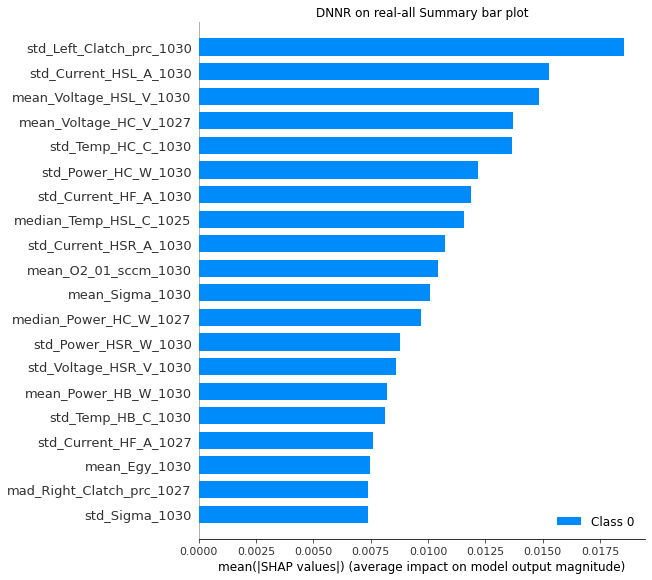

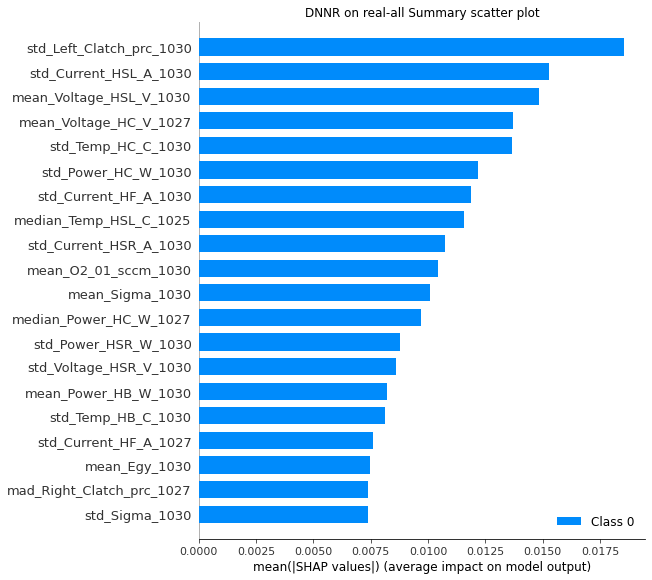

In [37]:
%%time
tmp = train_eval_a_nonsequential_regressor(x_train=x_r_train_real, 
                                      y_train=y_train_real, 
                                      x_val=x_r_val_real,
                                      y_val=y_val_real,
                                      x_test=x_r_test_real,
                                      y_test=y_test_real, 
                                      df_cmp=df_cmp_real,
                                      algorithm="DNNR", 
                                      data_type="real-all")



In [38]:
tmp



,MAE,MRAE,RMSE,R^2-Score,"Value, Name-1","Value, Name-2","Value, Name-3","Value, Name-4","Value, Name-5"
RF-Gini,0.010692,0.006285,0.017885,0.746730,"(0.37154, median_Temp_HF_C_1025)","(0.09166, mean_Right_Clatch_prc_1025)","(0.04252, mean_Temp_HSL_C_1030)","(0.02766, R FWHM)","(0.01740, Coolness_neg)"
RF-Perm,0.010692,0.006285,0.017885,0.746730,"(0.65639, median_Temp_HF_C_1025)","(0.10098, mean_Temp_HSL_C_1030)","(0.07108, R FWHM)","(0.07002, mean_Right_Clatch_prc_1025)","(0.03155, Coolness_neg)"
RF-Shap,0.010692,0.006285,0.017885,0.746730,"(0.01619, median_Temp_HF_C_1025)","(0.00449, mean_Right_Clatch_prc_1025)","(0.00268, mean_Temp_HSL_C_1030)","(0.00192, mean_Power_HF_W_1025)","(0.00174, mean_Voltage_HF_V_1025)"
GBR-Gini,0.014165,0.008317,0.021276,0.641596,"(0.30467, median_Temp_HF_C_1025)","(0.23305, mean_Right_Clatch_prc_1025)","(0.07652, mean_Temp_HSL_C_1025)","(0.04677, Y FWHM)","(0.04567, mean_Temp_HSL_C_1030)"
GBR-Perm,0.014165,0.008317,0.021276,0.641596,"(0.14245, mean_Right_Clatch_prc_1025)","(0.07805, median_Temp_HF_C_1025)","(0.04576, median_Left_Clatch_prc_1030)","(0.03544, X FWHM)","(0.02883, mean_Temp_HSL_C_1030)"
GBR-Shap,0.014165,0.008317,0.021276,0.641596,"(0.00736, mean_Right_Clatch_prc_1025)","(0.00573, median_Temp_HF_C_1025)","(0.00298, mean_Temp_HSL_C_1025)","(0.00290, X FWHM)","(0.00286, Coolness_neg)"
DNNR-Shap,0.038378,0.022406,0.048886,0.551338,"(0.01853, std_Left_Clatch_prc_1030)","(0.01528, std_Current_HSL_A_1030)","(0.01485, mean_Voltage_HSL_V_1030)","(0.01369, mean_Voltage_HC_V_1027)","(0.01365, std_Temp_HC_C_1030)"


In [49]:
df_cmp_real = pd.read_csv("final_comparison-real-all.csv")
df_cmp_real



,Unnamed: 0,MAE,MRAE,RMSE,R^2-Score,"Value, Name-1","Value, Name-2","Value, Name-3","Value, Name-4","Value, Name-5"
0,RF-Gini,0.010692,0.006285,0.017885,0.746730,"('0.37154', 'median_Temp_HF_C_1025')","('0.09166', 'mean_Right_Clatch_prc_1025')","('0.04252', 'mean_Temp_HSL_C_1030')","('0.02766', 'R FWHM')","('0.01740', 'Coolness_neg')"
1,RF-Perm,0.010692,0.006285,0.017885,0.746730,"('0.65639', 'median_Temp_HF_C_1025')","('0.10098', 'mean_Temp_HSL_C_1030')","('0.07108', 'R FWHM')","('0.07002', 'mean_Right_Clatch_prc_1025')","('0.03155', 'Coolness_neg')"
2,RF-Shap,0.010692,0.006285,0.017885,0.746730,"('0.01619', 'median_Temp_HF_C_1025')","('0.00449', 'mean_Right_Clatch_prc_1025')","('0.00268', 'mean_Temp_HSL_C_1030')","('0.00192', 'mean_Power_HF_W_1025')","('0.00174', 'mean_Voltage_HF_V_1025')"
3,GBR-Gini,0.014165,0.008317,0.021276,0.641596,"('0.30467', 'median_Temp_HF_C_1025')","('0.23305', 'mean_Right_Clatch_prc_1025')","('0.07652', 'mean_Temp_HSL_C_1025')","('0.04677', 'Y FWHM')","('0.04567', 'mean_Temp_HSL_C_1030')"
4,GBR-Perm,0.014165,0.008317,0.021276,0.641596,"('0.14245', 'mean_Right_Clatch_prc_1025')","('0.07805', 'median_Temp_HF_C_1025')","('0.04576', 'median_Left_Clatch_prc_1030')","('0.03544', 'X FWHM')","('0.02883', 'mean_Temp_HSL_C_1030')"
5,GBR-Shap,0.014165,0.008317,0.021276,0.641596,"('0.00736', 'mean_Right_Clatch_prc_1025')","('0.00573', 'median_Temp_HF_C_1025')","('0.00298', 'mean_Temp_HSL_C_1025')","('0.00290', 'X FWHM')","('0.00286', 'Coolness_neg')"
6,DNNR-Shap,0.038378,0.022406,0.048886,0.551338,"('0.01853', 'std_Left_Clatch_prc_1030')","('0.01528', 'std_Current_HSL_A_1030')","('0.01485', 'mean_Voltage_HSL_V_1030')","('0.01369', 'mean_Voltage_HC_V_1027')","('0.01365', 'std_Temp_HC_C_1030')"


# Sequential Regressions

We will make a set of predictions based on a window of consecutive samples from the data. More precisely, we will implement various models --including Sequential Dense NN Reg. (SDNNR), Sequential Convolutional NN Reg. (SCNNR), and Recurrent NN Reg. (SRNNR) models -- and predict based on a window of consecutive samples. So let us first implement this Window.


### Data windowing


The features of the input windows are:

- The width (number of time steps) of the input and label windows
- The time offset between them.
- Which features are used as inputs, labels, or both.
- Single-output and multi-output predictions.
- Single-time-step and multi-time-step predictions.






In [61]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)
        
        ds = ds.map(self.split_window)
        return ds
    
    

In [62]:
def convert_windowed_tf_to_numpy(windowed_data_df):
    
    # Converting data TF to Numpy array for using in SHAP Lib. (Not very efficient way! :( )
    # train data:
    data_np_y = []
    tmp_data = []
    
    for i, j in windowed_data_df:
        data_np_y += j.numpy().flatten().tolist()
        tmp_data.append(i.numpy())

    bs, w, f = tmp_data[0].shape  # batch_size, window_size, n_features
    n = sum([l.shape[0] for l in tmp_data])  # n_datapoints

    data_np_x = np.empty(shape=(n, w, f))
    interval = 0

    for t in range(len(tmp_data)):
        I, J, K = tmp_data[t].shape
        for i in range(I):
            for j in range(J):
                for k in range(K):
                    data_np_x[interval+i, j, k] = tmp_data[t][i, j, k]
        interval += I
        
    return data_np_x, data_np_y
    

In [63]:
def compile_and_fit(model, window):
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.make_dataset(train_df), epochs=n_epochs,
                      validation_data=window.make_dataset(val_df),
                       )
    
    y_preds = model.predict(window.make_dataset(test_df))
    y_preds = y_preds.flatten()
    
    x_train_np, y_train_np = convert_windowed_tf_to_numpy(window.make_dataset(train_df))
    x_test_np, y_test_np = convert_windowed_tf_to_numpy(window.make_dataset(test_df))
    
    return history, y_preds, y_train_np, x_train_np, y_test_np, x_test_np



In [81]:
def train_eval_a_sequential_regressor(train_df,
                                      val_df, 
                                      test_df,
                                      input_width, 
                                      label_width,
                                      shift,
                                      algorithm, 
                                      df_cmp, 
                                      data_type,
                                      label_columns):
    
    # wandb initilization
    run = init_a_wandb(name=None, 
                       project=project_,
                       notes="Sequential Regressions Comparison for SuperOX " + data_type, 
                       group=algorithm
                      )
    
    
    # Model instantiation
    if algorithm == "Baseline":
        print("Baseline is Running")
                
        model = tfk.Sequential([
            tfkl.Dense(units=1)
        ])
    
    
    if algorithm == "SDNNR":  # Dense NN with multi_step_window Reg.
        print("Dense TD Reg.")
        
        model = tfk.Sequential([
            tfkl.Dense(units=int(.5*n_units), activation=tf.nn.leaky_relu),
            tfkl.Dense(units=n_units, activation=tf.nn.leaky_relu),
            tfkl.Dense(units=2*n_units, activation=tf.nn.leaky_relu,),
            tfkl.Dense(units=4*n_units, activation=tf.nn.leaky_relu,), 
            tfkl.Dense(units=1)
        ])
        
    if algorithm == "SRNNR":
        print("Dense TD RNN Reg.")
        
        model = tf.keras.models.Sequential([
            # Shape [batch, time, features] => [batch, time, lstm_units]
            tf.keras.layers.LSTM(n_units, return_sequences=True),
            tf.keras.layers.LSTM(n_units, return_sequences=True),
            # Shape => [batch, time, features]
            tf.keras.layers.Dense(units=1)
        ])
        
    
    if algorithm == "SCNNR":
        print("Dense TD CNN Reg.")
        
        CONV_WIDTH = input_width
        
        model = tf.keras.Sequential([
            tfkl.Conv1D(filters=n_units,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
            tf.keras.layers.Dense(units=n_units, activation='relu'),
            tf.keras.layers.Dense(units=1),
        ])



    
    window = WindowGenerator(
        input_width=input_width, label_width=label_width, shift=shift,
        train_df=train_df, val_df=val_df, test_df=test_df,
        label_columns=[label_columns])

    print("window:", window)


    # Training and validation of the model
    
    history, y_preds_model, y_train_np, x_train_np, y_test_np, x_test_np = compile_and_fit(model, window)
    
    
    print("y_preds_model:", y_preds_model.shape, len(y_test_np))
    
    
    run = wandb_metrics(run=run, y_trues=y_test_np, y_preds=y_preds_model)
        
    run = save_model(run=run, model=model, 
                     name=algorithm.lower(), 
                     experiment_name=algorithm+"-"+data_type)
    
    
    # For now it is not available
    # explainer, shap_indices, shap_name, shap_val = apply_shap_summary_plot(model=model,
    #                                                 x_train=train_df, 
    #                                                 y_train=None, 
    #                                                 x_test=test_df, 
    #                                                 y_test=None, 
    #                                                 n_clusters=10,
    #                                                 model_name=algorithm, 
    #                                                 data_type=data_type
    #                                                )
    
    tmp = [1, 2, 3, 4, 5, 6]
    tmp_ = ["NaN", "NaN", "NaN", "NaN", "NaN", "NaN"]
    
    df_cmp = final_comparison(df=df_cmp, 
                              y_preds=y_preds_model,
                              y_trues=y_test_np, 
                              name=algorithm+'-Shap',
                              data_name=data_type,
                              indices=tmp,  # shap_indices,
                              values_features_importance=[tmp],  # shap_val,
                              name_important_features=tmp_  # shap_name
                             )
    
    model.save("saved_model/" + algorithm + "-" +data_type + ".h5")
    
    return df_cmp


In [76]:
project_ = "Sequential Regressions-all"

train_df = x_r_train_real_seq
test_df = x_r_test_real_seq
val_df = x_r_val_real_seq



In [78]:
%%time
tmp_ = train_eval_a_sequential_regressor(train_df=train_df, 
                                         val_df=val_df,
                                         test_df=test_df,
                                         input_width=1,  # the main difference
                                         label_width=1,  # the main difference
                                         shift=1,
                                         algorithm="Baseline", 
                                         df_cmp=df_cmp_real_seq,
                                         data_type="real-Seq",
                                         label_columns="Ic_norm", 
                                        )



Baseline is Running
window: Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Ic_norm']
Epoch 1/1000
348/348 [==============================] - 1s 1ms/step - loss: 0.7492 - mean_absolute_error: 0.6856 - val_loss: 1.7300 - val_mean_absolute_error: 0.9875
Epoch 2/1000
348/348 [==============================] - 0s 1ms/step - loss: 0.0273 - mean_absolute_error: 0.1302 - val_loss: 1.9194 - val_mean_absolute_error: 0.9969
Epoch 3/1000
348/348 [==============================] - 0s 1ms/step - loss: 0.0089 - mean_absolute_error: 0.0734 - val_loss: 1.9417 - val_mean_absolute_error: 0.9513
Epoch 4/1000
348/348 [==============================] - 0s 1ms/step - loss: 0.0046 - mean_absolute_error: 0.0525 - val_loss: 1.9289 - val_mean_absolute_error: 0.9014
Epoch 5/1000
348/348 [==============================] - 0s 1ms/step - loss: 0.0028 - mean_absolute_error: 0.0411 - val_loss: 1.9173 - val_mean_absolute_error: 0.8593
Epoch 6/1000
348/348 [===========================

Epoch 96/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.3060e-04 - mean_absolute_error: 0.0113 - val_loss: 1.0239 - val_mean_absolute_error: 0.4325
Epoch 97/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.3083e-04 - mean_absolute_error: 0.0114 - val_loss: 1.0112 - val_mean_absolute_error: 0.4274
Epoch 98/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.3727e-04 - mean_absolute_error: 0.0115 - val_loss: 1.0135 - val_mean_absolute_error: 0.4288
Epoch 99/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.3424e-04 - mean_absolute_error: 0.0114 - val_loss: 1.0005 - val_mean_absolute_error: 0.4266
Epoch 100/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2526e-04 - mean_absolute_error: 0.0112 - val_loss: 0.9929 - val_mean_absolute_error: 0.4277
Epoch 101/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.3073e-04 - mean_absolute_error: 0.0113 - val_loss: 0.9816 - val_

Epoch 191/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2803e-04 - mean_absolute_error: 0.0112 - val_loss: 0.5710 - val_mean_absolute_error: 0.3245
Epoch 192/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2391e-04 - mean_absolute_error: 0.0112 - val_loss: 0.5589 - val_mean_absolute_error: 0.3211
Epoch 193/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2062e-04 - mean_absolute_error: 0.0109 - val_loss: 0.5639 - val_mean_absolute_error: 0.3247
Epoch 194/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2659e-04 - mean_absolute_error: 0.0111 - val_loss: 0.5578 - val_mean_absolute_error: 0.3206
Epoch 195/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2497e-04 - mean_absolute_error: 0.0111 - val_loss: 0.5595 - val_mean_absolute_error: 0.3202
Epoch 196/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2979e-04 - mean_absolute_error: 0.0112 - val_loss: 0.5566 - 

Epoch 286/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1952e-04 - mean_absolute_error: 0.0109 - val_loss: 0.4253 - val_mean_absolute_error: 0.2817
Epoch 287/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1801e-04 - mean_absolute_error: 0.0109 - val_loss: 0.4271 - val_mean_absolute_error: 0.2824
Epoch 288/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.3196e-04 - mean_absolute_error: 0.0114 - val_loss: 0.4270 - val_mean_absolute_error: 0.2819
Epoch 289/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.3059e-04 - mean_absolute_error: 0.0111 - val_loss: 0.4248 - val_mean_absolute_error: 0.2802
Epoch 290/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1585e-04 - mean_absolute_error: 0.0108 - val_loss: 0.4271 - val_mean_absolute_error: 0.2860
Epoch 291/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2698e-04 - mean_absolute_error: 0.0112 - val_loss: 0.4232 - 

Epoch 381/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1517e-04 - mean_absolute_error: 0.0108 - val_loss: 0.3683 - val_mean_absolute_error: 0.2616
Epoch 382/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1687e-04 - mean_absolute_error: 0.0107 - val_loss: 0.3750 - val_mean_absolute_error: 0.2639
Epoch 383/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2491e-04 - mean_absolute_error: 0.0110 - val_loss: 0.3705 - val_mean_absolute_error: 0.2651
Epoch 384/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2370e-04 - mean_absolute_error: 0.0110 - val_loss: 0.3727 - val_mean_absolute_error: 0.2628
Epoch 385/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1330e-04 - mean_absolute_error: 0.0107 - val_loss: 0.3752 - val_mean_absolute_error: 0.2649
Epoch 386/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1765e-04 - mean_absolute_error: 0.0108 - val_loss: 0.3706 - 

Epoch 476/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1738e-04 - mean_absolute_error: 0.0108 - val_loss: 0.3526 - val_mean_absolute_error: 0.2565
Epoch 477/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2588e-04 - mean_absolute_error: 0.0110 - val_loss: 0.3532 - val_mean_absolute_error: 0.2577
Epoch 478/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1830e-04 - mean_absolute_error: 0.0109 - val_loss: 0.3541 - val_mean_absolute_error: 0.2568
Epoch 479/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1968e-04 - mean_absolute_error: 0.0109 - val_loss: 0.3532 - val_mean_absolute_error: 0.2586
Epoch 480/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1602e-04 - mean_absolute_error: 0.0108 - val_loss: 0.3509 - val_mean_absolute_error: 0.2554
Epoch 481/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2031e-04 - mean_absolute_error: 0.0109 - val_loss: 0.3525 - 

Epoch 571/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1967e-04 - mean_absolute_error: 0.0108 - val_loss: 0.3406 - val_mean_absolute_error: 0.2535
Epoch 572/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2951e-04 - mean_absolute_error: 0.0112 - val_loss: 0.3389 - val_mean_absolute_error: 0.2542
Epoch 573/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2316e-04 - mean_absolute_error: 0.0111 - val_loss: 0.3399 - val_mean_absolute_error: 0.2551
Epoch 574/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2041e-04 - mean_absolute_error: 0.0109 - val_loss: 0.3369 - val_mean_absolute_error: 0.2518
Epoch 575/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1340e-04 - mean_absolute_error: 0.0107 - val_loss: 0.3389 - val_mean_absolute_error: 0.2534
Epoch 576/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2338e-04 - mean_absolute_error: 0.0109 - val_loss: 0.3392 - 

Epoch 666/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1646e-04 - mean_absolute_error: 0.0107 - val_loss: 0.3306 - val_mean_absolute_error: 0.2487
Epoch 667/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1291e-04 - mean_absolute_error: 0.0107 - val_loss: 0.3286 - val_mean_absolute_error: 0.2480
Epoch 668/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1975e-04 - mean_absolute_error: 0.0109 - val_loss: 0.3325 - val_mean_absolute_error: 0.2508
Epoch 669/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2058e-04 - mean_absolute_error: 0.0109 - val_loss: 0.3321 - val_mean_absolute_error: 0.2530
Epoch 670/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1522e-04 - mean_absolute_error: 0.0107 - val_loss: 0.3314 - val_mean_absolute_error: 0.2485
Epoch 671/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2408e-04 - mean_absolute_error: 0.0110 - val_loss: 0.3354 - 

Epoch 761/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1813e-04 - mean_absolute_error: 0.0108 - val_loss: 0.3251 - val_mean_absolute_error: 0.2482
Epoch 762/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2317e-04 - mean_absolute_error: 0.0110 - val_loss: 0.3244 - val_mean_absolute_error: 0.2461
Epoch 763/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.3008e-04 - mean_absolute_error: 0.0112 - val_loss: 0.3247 - val_mean_absolute_error: 0.2490
Epoch 764/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2637e-04 - mean_absolute_error: 0.0111 - val_loss: 0.3218 - val_mean_absolute_error: 0.2453
Epoch 765/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1836e-04 - mean_absolute_error: 0.0108 - val_loss: 0.3243 - val_mean_absolute_error: 0.2463
Epoch 766/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2215e-04 - mean_absolute_error: 0.0109 - val_loss: 0.3266 - 

Epoch 856/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2000e-04 - mean_absolute_error: 0.0109 - val_loss: 0.3224 - val_mean_absolute_error: 0.2465
Epoch 857/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1535e-04 - mean_absolute_error: 0.0107 - val_loss: 0.3225 - val_mean_absolute_error: 0.2481
Epoch 858/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1622e-04 - mean_absolute_error: 0.0108 - val_loss: 0.3219 - val_mean_absolute_error: 0.2456
Epoch 859/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.3031e-04 - mean_absolute_error: 0.0112 - val_loss: 0.3190 - val_mean_absolute_error: 0.2449
Epoch 860/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1524e-04 - mean_absolute_error: 0.0107 - val_loss: 0.3220 - val_mean_absolute_error: 0.2451
Epoch 861/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1668e-04 - mean_absolute_error: 0.0108 - val_loss: 0.3223 - 

Epoch 951/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.3641e-04 - mean_absolute_error: 0.0114 - val_loss: 0.3145 - val_mean_absolute_error: 0.2440
Epoch 952/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2496e-04 - mean_absolute_error: 0.0110 - val_loss: 0.3137 - val_mean_absolute_error: 0.2418
Epoch 953/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1704e-04 - mean_absolute_error: 0.0108 - val_loss: 0.3164 - val_mean_absolute_error: 0.2434
Epoch 954/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.1560e-04 - mean_absolute_error: 0.0108 - val_loss: 0.3167 - val_mean_absolute_error: 0.2453
Epoch 955/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2090e-04 - mean_absolute_error: 0.0109 - val_loss: 0.3145 - val_mean_absolute_error: 0.2422
Epoch 956/1000
348/348 [==============================] - 0s 1ms/step - loss: 2.2217e-04 - mean_absolute_error: 0.0109 - val_loss: 0.3113 - 

In [79]:
tmp_



,MAE,MRAE,RMSE,R^2-Score,"Value, Name-1","Value, Name-2","Value, Name-3","Value, Name-4","Value, Name-5"
Baseline-Shap,1.737024,1.027496,1.770148,-2977.53698,"(2.00000, NaN)","(3.00000, NaN)","(4.00000, NaN)","(5.00000, NaN)","(6.00000, NaN)"
SDNNR-Shap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SCNNR-Shap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SRNNR-Shap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
%%time
tmp_ = train_eval_a_sequential_regressor(train_df=train_df, 
                                         val_df=val_df,
                                         test_df=test_df,
                                         input_width=1,  # the main difference
                                         label_width=1,  # the main difference
                                         shift=1,
                                         algorithm="SDNNR", 
                                         df_cmp=df_cmp_real_seq,
                                         data_type="real-Seq",
                                         label_columns="Ic_norm", 
                                        )



MAE,1.73702
MRAE,1.0275
RMSE,1.77015
R^2-Score,-2977.53698
_runtime,406
_timestamp,1618329058
_step,0


MAE,▁
MRAE,▁
RMSE,▁
R^2-Score,▁
_runtime,▁
_timestamp,▁
_step,▁


Dense TD Reg.
window: Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Ic_norm']
Epoch 1/1000
348/348 [==============================] - 1s 2ms/step - loss: 0.1536 - mean_absolute_error: 0.1972 - val_loss: 0.1405 - val_mean_absolute_error: 0.2122
Epoch 2/1000
348/348 [==============================] - 1s 2ms/step - loss: 9.8620e-04 - mean_absolute_error: 0.0243 - val_loss: 0.1497 - val_mean_absolute_error: 0.1994
Epoch 3/1000
348/348 [==============================] - 1s 2ms/step - loss: 5.8157e-04 - mean_absolute_error: 0.0189 - val_loss: 0.1559 - val_mean_absolute_error: 0.2016
Epoch 4/1000
348/348 [==============================] - 1s 2ms/step - loss: 6.2991e-04 - mean_absolute_error: 0.0198 - val_loss: 0.1576 - val_mean_absolute_error: 0.1993
Epoch 5/1000
348/348 [==============================] - 1s 2ms/step - loss: 5.4526e-04 - mean_absolute_error: 0.0181 - val_loss: 0.1516 - val_mean_absolute_error: 0.1911
Epoch 6/1000
348/348 [=================

In [ ]:
tmp_



In [ ]:
%%time
tmp_ = train_eval_a_sequential_regressor(train_df=train_df, 
                                         val_df=val_df,
                                         test_df=test_df,
                                         input_width=3,  # the main difference 
                                         label_width=1,  # the main difference
                                         shift=1,
                                         algorithm="SCNNR", 
                                         df_cmp=df_cmp_real_seq,
                                         data_type="real-Seq",
                                         label_columns="Ic_norm", 
                                        )




In [ ]:
tmp_


In [ ]:
%%time
tmp_ = train_eval_a_sequential_regressor(train_df=train_df, 
                                         val_df=val_df,
                                         test_df=test_df,
                                         input_width=24,  # the main difference
                                         label_width=24,  # the main difference
                                         shift=1,
                                         algorithm="SRNNR", 
                                         df_cmp=df_cmp_real_seq,
                                         data_type="real-Seq",
                                         label_columns="Ic_norm", 
                                        )



In [ ]:
tmp_

#### Conclusion over real-only data:

- All three algorithms obtained acceptable results w.r.t MAE, MRAE, RMSE.

- Although all of these three also obtain acceptable r^2 score, however, RF is the winner

# Synthetic-only data

# Combined data

## Overall Conclusion:


<!-- This study trained three regressors over a) real-data; b) synthetically generated data; c) their combination.

We used four metrics to evaluate and compare the obtained results.

- W.r.t MAE, MRAE, RMSE, all three algorithms, obtained excellent results over all three types of data sets.

- W.r.t R^2 score, DNN-Reg obtained outstanding results over synthetic only data. It is also a close follower of the combined data set winner, which is RF. 

- RF wins the combined and real-only data, with relatively acceptable results.



Future work: 

- I am going to re-train DNN-Reg with more epochs and smaller batch-size to improve its performance (hopefully). 

 -->

In [ ]:
# def create_windowed_dataset(X, y, time_steps):
#     Xs, ys = [], []
#     for i in range(len(X)-time_steps):
#         v = X.iloc[i:(i+time_steps)].values
#         Xs.append(v)
#         ys.append(y.iloc[i+time_steps])
#     return np.asarray(Xs), np.asarray(ys)

In [ ]:
# def windowed_dataset(X, y, time_steps):
#     ds = tfk.preprocessing.timeseries_dataset_from_array(
#         data=X,
#         targets=y,
#         sequence_length=time_steps,
#         sequence_stride=1,
#         shuffle=False,
#     )
    return ds